In [1]:
import numpy as np
import pandas as pd
import cv2
import datetime
import ast
from clickbait import *

### Search for Clickbait Sessions

In [2]:
# Where to look for clickbait datasets
data_dir = f'data/'

# Get session and filenames for directories with .avi files greater than 1gb
datasets, sessions, files = scan_dataset(data_dir, min_size_bytes=1e9, filetype='.avi')

### Load data for a single session.

In [3]:
# Set session index
idx = 0

# Set path and filename prefix
data_path = f"{data_dir}{datasets[idx]}/{sessions[idx]}/{files[idx]}"

# Get video filename
video_filename = f"{data_path}.avi"

# Load video timestamps
video_ts = pd.read_csv(f"{data_path}_video_timestamp.csv")
video_ts.columns = ['timestamp']

# Load events .csv part A
col_names_a = ['trial_number', 'timestamp', 'poke_left', 'poke_right', 'centroid_x', 'centroid_y', 'target_cell']
event_data_a = pd.read_csv(f"{data_path}_eventsA.csv")
event_data_a.columns = col_names_a
pd.to_datetime(event_data_a['timestamp'])

# Load events .csv part B
col_names_b = ['iti', 'reward_state', 'water_left', 'water_right', 'click']
event_data_b = pd.read_csv(f"{data_path}_eventsB.csv")
event_data_b.columns = col_names_b

# Concatenate eventsA abd eventsB dataframes
if len(event_data_a) == len(event_data_b):
    event_data = pd.concat([event_data_a, event_data_b], axis=1)
else:
    print("Event dataframes must contain same number of rows")
    min_length = min(len(event_data_a), len(event_data_b))
    max_length = max(len(event_data_a), len(event_data_b))
    print(f"Trimmed long dataframe by {max_length-min_length} rows.")
    event_data_a = event_data_a.iloc[:min_length]  [:-1]
    event_data_b = event_data_b.iloc[:min_length]
    event_data = pd.concat([event_data_a, event_data_b], axis=1)

#Set types for each column in the dataframe
event_data = event_data.astype({
    'trial_number': 'uint8',
    'timestamp': 'datetime64[ns]',
    'poke_left': 'bool',
    'poke_right': 'bool',
    'centroid_x': 'uint16',
    'centroid_y': 'uint16',
    'target_cell': 'str',
    'iti': 'bool',
    'water_left': 'bool',
    'water_right': 'bool',
    'reward_state': 'bool',
    'click': 'bool'})

# Convert string representations of lists to actual lists
event_data['target_cell'] = event_data['target_cell'].apply(ast.literal_eval)

# Check Lengths of video and events dataframe
print(f"Video length: {len(video_ts)} frames")
print(f"Events Data Length: {len(event_data)} rows")

Video length: 128973 frames
Events Data Length: 284385 rows


### Resample to synch event and video timestamps

In [4]:
# Synchronize events data with video, using nearest matches in the 'timestamp' column 
video_ts['timestamp'] = pd.to_datetime(video_ts['timestamp'])
event_data['timestamp'] = pd.to_datetime(event_data['timestamp'])

# Set 'timestamp' as the index of each dataframe
video_ts = video_ts.set_index('timestamp')
event_data = event_data.set_index('timestamp')

# Map event_data onto the video_data timestamps, using nearest matches between timestamps
event_data = event_data.reindex(video_ts.index, method='nearest')
video_ts = video_ts.reset_index()
event_data = event_data.reset_index()

# Check that event dataframe is the same length as video frames
print(f"Data resampled to match video length:")
print(f"Video length: {len(video_ts)} frames")
print(f"Events Data Length: {len(event_data)} rows")

Data resampled to match video length:
Video length: 128973 frames
Events Data Length: 128973 rows


### Preview Events Dataframe

In [5]:
event_data.loc[event_data['trial_number'] == 106]

,timestamp,trial_number,poke_left,poke_right,centroid_x,centroid_y,target_cell,iti,reward_state,water_left,water_right,click
124049,2024-11-13 16:13:21.418956800,106,False,False,214,862,[0],False,False,False,False,False
124050,2024-11-13 16:13:21.439628800,106,False,False,214,862,[0],False,False,False,False,False
124051,2024-11-13 16:13:21.462118400,106,False,False,213,861,[0],False,False,False,False,False
124052,2024-11-13 16:13:21.481996800,106,False,False,213,861,[0],False,False,False,False,False
124053,2024-11-13 16:13:21.501196800,106,False,False,213,862,[0],False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
128968,2024-11-13 16:15:05.942707200,106,False,False,438,487,[],False,True,False,False,False
128969,2024-11-13 16:15:06.035545600,106,False,False,264,957,[],False,True,False,False,False
128970,2024-11-13 16:15:06.098547200,106,False,False,258,959,[],False,True,False,False,False
128971,2024-11-13 16:15:06.158784000,106,False,False,251,962,[],False,True,False,False,False


### Visualize Trajectories

In [6]:
# Extract list of trials from session
trials_list = event_data['trial_number'].unique().tolist()
print(trials_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


In [7]:
visualize_trial(event_data, trial_number=trials_list, color_code="trial_number", target_frame=True, opacity=.5)

c:\Git Repos\clickbait-analyze\clickbait.py:137: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Index([   226,   3225,   5544,   7240,   8155,   9012,  10723,  11499,  12238,
        13074,
       ...
       101542, 102166, 105418, 116039, 116542, 117187, 119093, 119383, 122573,
       128933],
      dtype='int64', length=107)


In [8]:
# Set video dimensions in pixels
scale = 2 # Reduction factor
dim_x = 894//scale  
dim_y = 1952//scale

# Create GidMaze object
grid = GridMaze((dim_y,dim_x),(9,4), border=True) #15, 7

In [9]:
single_trial = False
display = True
write = False
loop = False

if single_trial:
    test_data = event_data.loc[event_data['trial_number'].isin([20])].copy()
    ii = test_data.index[0]

else:
    test_data = event_data.copy()
    ii = 0  # Start from 0

# Load video
video = cv2.VideoCapture(video_filename)
video.set(cv2.CAP_PROP_POS_FRAMES, ii)

# Display video with event overlay
while True:
    # Load video frame

    ret, frame = video.read()
    frame = cv2.resize(frame, (frame.shape[1]//scale, frame.shape[0]//scale)).astype(np.uint8)
    
    current_frame = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # Draw Grid
    frame = grid.draw_grid(frame, color=(0,0,0), opacity=.25).astype(np.uint8)

    # Draw target
    target = grid.get_target_cell(test_data['target_cell'][ii])
    frame = cv2.rectangle(frame, target[0], target[1], (0,0,0), -1)

    # Get mouse centroid
    pt_x = test_data['centroid_x'][ii]//scale
    pt_y = test_data['centroid_y'][ii]//scale

    # Get mouse cell and draw
    cell_i, cell_j = grid.get_mouse_cell(pt_x, pt_y)
    frame = grid.draw_cell(frame, cell_i, cell_j, (128,128,255), -1, opacity=.25)

    # Draw mouse centroid
    frame = cv2.circle(frame, (pt_x, pt_y), 5, (255,255,255), -1, cv2.LINE_AA)

    # Set state color for trial number
    if test_data['iti'][ii] == True:
        state_color = (128,128,255)
    elif test_data['reward_state'][ii] == True:
        state_color = (128,255,128)
    elif test_data['reward_state'][ii] == False and len(test_data['target_cell'][ii]) == 0:
        state_color = (128,255,128)
    else:
        state_color = (255,128,128)

    # Draw trial number in state color
    frame = cv2.putText(frame, str(test_data['trial_number'][ii]), (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, state_color, 2, cv2.LINE_AA)
    # Draw video frame number
    frame_count = f"Video frame: {current_frame}, DataFrame index: {ii}"
    #frame = cv2.putText(frame, frame_count, (20,60), cv2.FONT_HERSHEY_SIMPLEX, .5, (255,255,255), 1, cv2.LINE_AA)

    # Display frame
    if display:
        cv2.imshow("clickbait", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    if write:
        cv2.imwrite(f"output/frame_{ii}.jpg", frame)

    # Increase counter
    ii += 1

    # Loop counter if needed
    if loop:
        if ii >= test_data.index[-1]:
            ii = test_data.index[0]
            video.set(cv2.CAP_PROP_POS_FRAMES, ii) 
    else:
        if ii >= test_data.index[-1]:
            break

cv2.destroyAllWindows()

In [10]:
test_data

,timestamp,trial_number,poke_left,poke_right,centroid_x,centroid_y,target_cell,iti,reward_state,water_left,water_right,click
0,2024-11-13 15:29:38.513318400,0,False,True,726,899,[12],False,False,False,False,False
1,2024-11-13 15:29:38.527091200,0,False,True,726,899,[12],False,False,False,False,False
2,2024-11-13 15:29:38.552972800,0,False,True,726,899,[12],False,False,False,False,False
3,2024-11-13 15:29:38.566489600,0,False,True,726,899,[12],False,False,False,False,False
4,2024-11-13 15:29:38.583308800,0,False,True,726,899,[12],False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
128968,2024-11-13 16:15:05.942707200,106,False,False,438,487,[],False,True,False,False,False
128969,2024-11-13 16:15:06.035545600,106,False,False,264,957,[],False,True,False,False,False
128970,2024-11-13 16:15:06.098547200,106,False,False,258,959,[],False,True,False,False,False
128971,2024-11-13 16:15:06.158784000,106,False,False,251,962,[],False,True,False,False,False


In [11]:
from clickbait import create_occupancy_histogram

In [19]:
no_drink = event_data.loc[event_data['target_cell'].apply(lambda x: len(x) == 0)]

Grid size: 15 x 34 bins
Bin size: 50.00 units


(<Figure size 800x1908.3 with 2 Axes>,
 <Axes: title={'center': 'Occupancy Histogram'}, xlabel='centroid_x', ylabel='centroid_y'>)

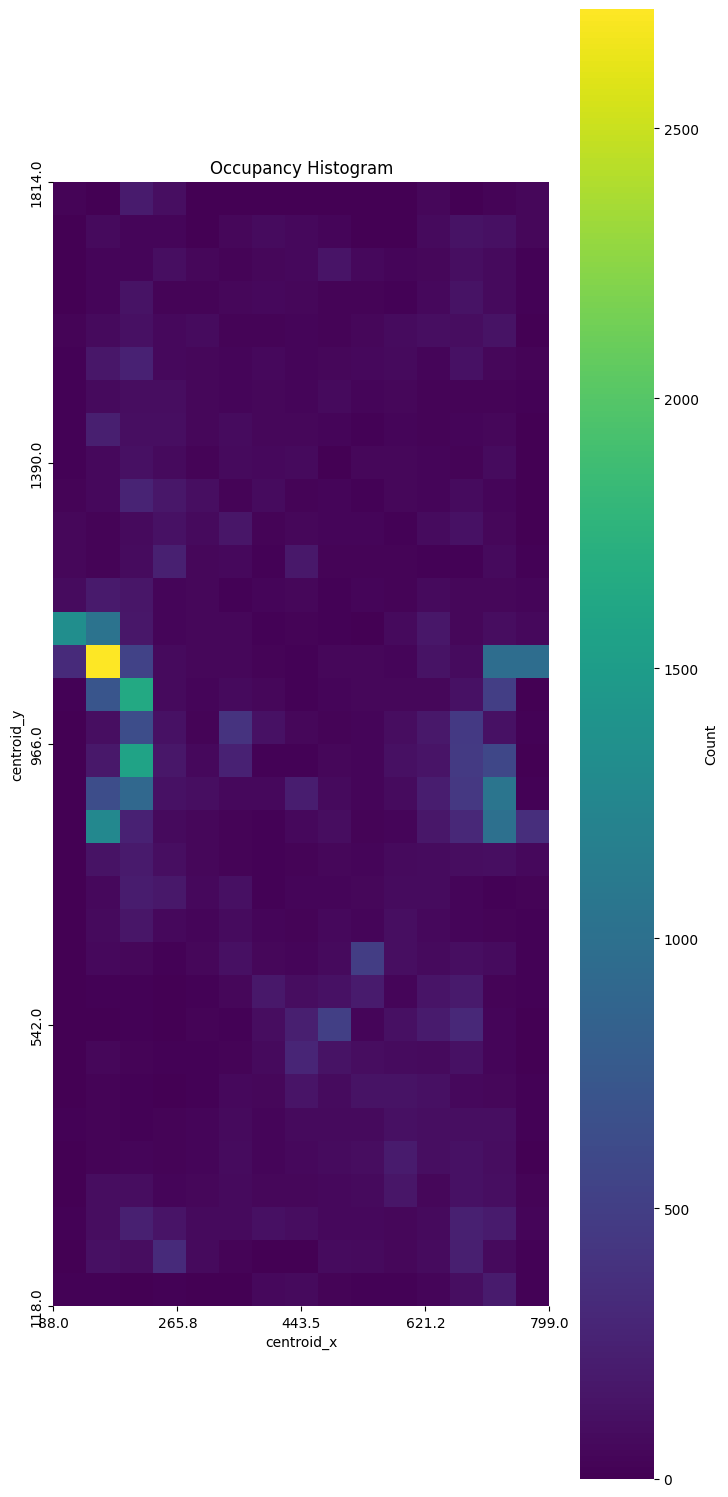

In [21]:
create_occupancy_histogram(no_drink, 'centroid_x', 'centroid_y', bin_size=50)

In [13]:
for ii in range(10):
    print(ii)

0
1
2
3
4
5
6
7
8
9


In [14]:
for ii in range(1,10):
    print(ii)

1
2
3
4
5
6
7
8
9


In [15]:
for ii in range(0,12,2):
    print(ii)

0
2
4
6
8
10


In [16]:
[::5]

SyntaxError: invalid syntax (3676738980.py, line 1)